# Image Compression Techniques - Part B Coding
This notebook implements various image compression techniques including DCT, Huffman Encoding, LZW Encoding, Run-Length Encoding, and Arithmetic Coding. Each method's performance will be evaluated by calculating the Compression Ratio and RMSE for a sample image.

In [46]:
# Importing necessary libraries
import numpy as np
import cv2
from scipy.fftpack import dct, idct
from heapq import heapify, heappop, heappush
import matplotlib.pyplot as plt
import heapq
from collections import Counter, defaultdict

# Helper function to calculate RMSE
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Load and preprocess the image (grayscale and resize if necessary)
def load_image(path, size=(256, 256)):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if size:
        image = cv2.resize(image, size)
    return image

# Display original, compressed, and reconstructed images for visual comparison
def display_images(original, compressed, title1="Original", title2="Compressed"):
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(title1)
    plt.subplot(1, 2, 2)
    plt.imshow(compressed, cmap='gray')
    plt.title(title2)
    plt.show()


# Specify the path to your image
image_path = 'namjoon_grayscale.jpg'  # Replace with your actual image path

# Load the image
image = load_image(image_path)


## 1. Transform Coding Using DCT

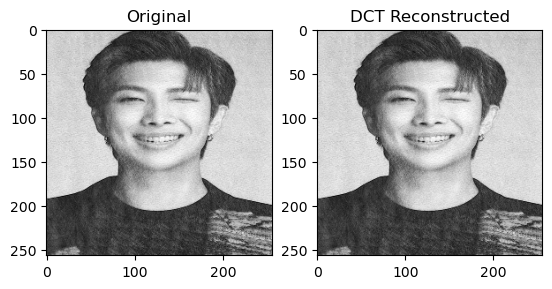

DCT Compression RMSE: 0.6528113967499055


In [47]:
# Transform Coding using DCT
def dct_transform(image, block_size=8):
    height, width = image.shape
    transformed = np.zeros_like(image, dtype=np.float32)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            transformed[i:i+block_size, j:j+block_size] = dct_block
    return transformed

# Inverse DCT
def idct_transform(transformed, block_size=8):
    height, width = transformed.shape
    reconstructed = np.zeros_like(transformed, dtype=np.float32)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = transformed[i:i+block_size, j:j+block_size]
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            reconstructed[i:i+block_size, j:j+block_size] = idct_block
    return np.clip(reconstructed, 0, 255).astype(np.uint8)

# Testing DCT
image = load_image(image_path)
transformed_image = dct_transform(image)
reconstructed_image = idct_transform(transformed_image)
display_images(image, reconstructed_image, title2='DCT Reconstructed')
print('DCT Compression RMSE:', calculate_rmse(image, reconstructed_image))

## 2. Huffman Encoding

Compression Ratio (Huffman): 1.12
Root Mean Square Error (RMSE) (Huffman): 0.00


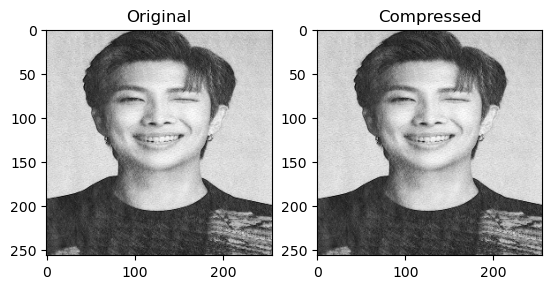

In [58]:
class HuffmanNode:
    def __init__(self, symbol=None, frequency=0):
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequency):
    # Create a priority queue of Huffman nodes
    priority_queue = [HuffmanNode(symbol, freq) for symbol, freq in frequency.items()]
    heapq.heapify(priority_queue)
    
    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = HuffmanNode(frequency=left.frequency + right.frequency)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)
        
    return priority_queue[0]

def build_huffman_codes(node, prefix="", codebook={}):
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    else:
        build_huffman_codes(node.left, prefix + "0", codebook)
        build_huffman_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(image):
    # Flatten the image and calculate the frequency of each pixel value
    flat_image = image.flatten()
    frequency = Counter(flat_image)
    
    # Build the Huffman tree and codebook
    root = build_huffman_tree(frequency)
    codebook = build_huffman_codes(root)
    
    # Encode the image
    encoded_image = ''.join(codebook[pixel] for pixel in flat_image)
    return encoded_image, codebook

def huffman_decode(encoded_image, codebook, shape):
    # Reverse the codebook for decoding
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_pixels, buffer = [], ""
    
    for bit in encoded_image:
        buffer += bit
        if buffer in reverse_codebook:
            decoded_pixels.append(reverse_codebook[buffer])
            buffer = ""
            
    return np.array(decoded_pixels).reshape(shape)

def calculate_compression_ratio_huffman(original, encoded_image):
    original_size = original.size * 8  # Size in bits (assuming 8 bits per pixel)
    compressed_size = len(encoded_image)  # Length of the encoded string in bits
    return original_size / compressed_size



# Huffman Encoding
encoded_image, codebook = huffman_encode(image)

# Huffman Decoding
reconstructed_image_array = huffman_decode(encoded_image, codebook,image.shape)

# Calculate Compression Ratio
compression_ratio = calculate_compression_ratio_huffman(image, encoded_image)
print(f"Compression Ratio (Huffman): {compression_ratio:.2f}")

# Calculate RMSE
rmse = calculate_rmse(image, reconstructed_image_array)
print(f"Root Mean Square Error (RMSE) (Huffman): {rmse:.2f}")

# Display the original and reconstructed images
display_images(image, reconstructed_image_array, title1="Original", title2="Compressed")


## 3. LZW Encoding

Compression Ratio: 1.83
Root Mean Square Error (RMSE): 0.00


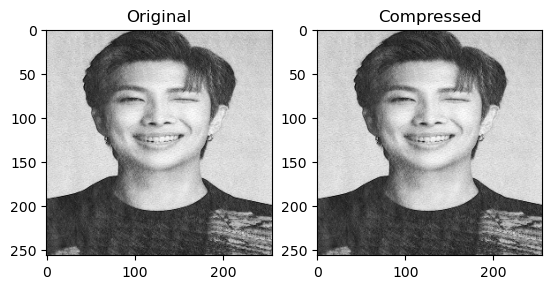

In [59]:
# Function to perform LZW encoding on an image
def lzw_encode(image):
    # Convert image array to a 1D string representation for LZW compression
    image_str = ''.join(map(chr, image.flatten()))
    
    # Initialize the dictionary with single character entries
    dictionary = {chr(i): i for i in range(256)}
    code = []
    s = ""
    
    for symbol in image_str:
        if s + symbol in dictionary:
            s += symbol
        else:
            code.append(dictionary[s])
            dictionary[s + symbol] = len(dictionary)
            s = symbol
    
    # Append the last code if there is any remaining
    if s:
        code.append(dictionary[s])
    
    return code, dictionary

# Function to decode an LZW compressed image
def lzw_decode(code, dictionary, shape):
    # Reverse the dictionary to map codes back to patterns
    reverse_dict = {v: k for k, v in dictionary.items()}
    
    # Initialize the decoded string with the first character from the code
    s = reverse_dict[code[0]]
    result = [ord(c) for c in s]
    
    for k in code[1:]:
        # Handle the case where k is not in reverse_dict
        if k in reverse_dict:
            entry = reverse_dict[k]
        else:
            entry = s + s[0]
        
        # Add the pattern to the decoded output
        result.extend(ord(c) for c in entry)
        
        # Update the dictionary for the next code
        reverse_dict[len(reverse_dict)] = s + entry[0]
        s = entry
    
    # Reshape the decoded result back into the original image shape
    return np.array(result).reshape(shape)

# Function to calculate Compression Ratio
def calculate_compression_ratio(original, compressed):
    original_size = original.size * 8  # size in bits (assuming 8 bits per pixel)
    compressed_size = len(compressed) * 8  # each code is assumed to be 8 bits
    return original_size / compressed_size


# Perform LZW encoding and decoding
lzw_encoded, dictionary = lzw_encode(image)
lzw_reconstructed = lzw_decode(lzw_encoded, dictionary, image.shape)

# Calculate Compression Ratio
compression_ratio = calculate_compression_ratio(image, lzw_encoded)
print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate RMSE
rmse = calculate_rmse(image, lzw_reconstructed)
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

# Display the original and reconstructed images
display_images(image, lzw_reconstructed, title1="Original", title2="Compressed")


## 4. Run-Length Encoding

Compression Ratio: 0.52
Root Mean Square Error (RMSE): 0.00


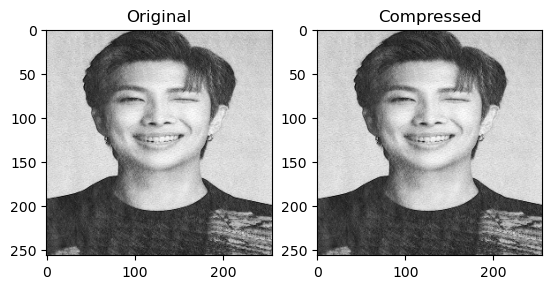

In [62]:
# Function to perform Run-Length Encoding on an image
def rle_encode(image):
    # Flatten the image array to a 1D array for easier processing with RLE
    flat_image = image.flatten()
    encoded = []
    last_pixel = flat_image[0]
    count = 1
    
    # Iterate through the flattened array and count consecutive pixels
    for pixel in flat_image[1:]:
        if pixel == last_pixel:
            count += 1
        else:
            encoded.append((last_pixel, count))
            last_pixel = pixel
            count = 1
    
    # Append the last run
    encoded.append((last_pixel, count))
    return encoded

# Function to decode an RLE compressed image
def rle_decode(encoded, shape):
    # Reconstruct the image from the encoded list
    decoded = np.concatenate([[pixel] * count for pixel, count in encoded])
    return decoded.reshape(shape)

# Function to calculate Compression Ratio
def calculate_compression_ratio(original, compressed):
    original_size = original.size * 8  # size in bits (assuming 8 bits per pixel)
    compressed_size = len(compressed) * (8 + 8)  # 8 bits for pixel + 8 bits for count
    return original_size / compressed_size

# Perform RLE encoding and decoding
rle_encoded = rle_encode(image)
rle_reconstructed = rle_decode(rle_encoded, image.shape)

# Calculate Compression Ratio
compression_ratio = calculate_compression_ratio(image, rle_encoded)
print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate RMSE
rmse = calculate_rmse(image, rle_reconstructed)
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

# Display the original and reconstructed images
display_images(image, rle_reconstructed, title1="Original", title2="Compressed")


## 5. Arithmetic Coding
####  Block-Based Arithmetic Coding

Compression Ratio: 8.16
Root Mean Square Error (RMSE): 6.95


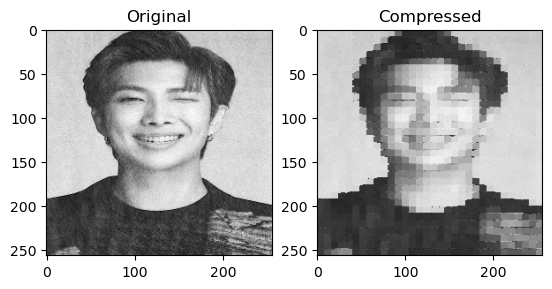

In [64]:
original_shape = image.shape

# Function to calculate probability ranges for each pixel value
def calculate_prob_ranges(sequence):
    total_pixels = len(sequence)
    freq = Counter(sequence)
    prob_ranges = {}
    current_low = 0.0

    for pixel_value, count in sorted(freq.items()):
        probability = count / total_pixels
        current_high = current_low + probability
        prob_ranges[pixel_value] = (current_low, current_high)
        current_low = current_high

    return prob_ranges

# Arithmetic encoding for a single sequence
def arithmetic_encode(sequence, prob_ranges):
    low, high = 0.0, 1.0
    for pixel in sequence:
        pixel_low, pixel_high = prob_ranges[pixel]
        range_ = high - low
        high = low + range_ * pixel_high
        low = low + range_ * pixel_low
    return (low + high) / 2  # Encoded as a single value within the final range

# Arithmetic decoding function for a single sequence
def arithmetic_decode(encoded_value, prob_ranges, sequence_length):
    low, high = 0.0, 1.0
    decoded_sequence = []
    for _ in range(sequence_length):
        range_ = high - low
        for pixel, (pixel_low, pixel_high) in prob_ranges.items():
            pixel_range_low = low + range_ * pixel_low
            pixel_range_high = low + range_ * pixel_high
            if pixel_range_low <= encoded_value < pixel_range_high:
                decoded_sequence.append(pixel)
                low, high = pixel_range_low, pixel_range_high
                break
    return decoded_sequence

# Define block size (e.g., 8x8)
block_size = 8
compressed_bits = 0
decoded_image = np.zeros_like(image)

# Perform encoding and decoding in blocks
for i in range(0, original_shape[0], block_size):
    for j in range(0, original_shape[1], block_size):
        # Get the block
        block = image[i:i+block_size, j:j+block_size].flatten()
        
        # Step 1: Calculate probability ranges for the block
        prob_ranges = calculate_prob_ranges(block)
        
        # Step 2: Encode the block
        encoded_value = arithmetic_encode(block, prob_ranges)
        
        # Step 3: Decode the block
        decoded_block = arithmetic_decode(encoded_value, prob_ranges, len(block))
        decoded_image[i:i+block_size, j:j+block_size] = np.array(decoded_block).reshape(block_size, block_size)
        
        # Calculate required bits for the encoded value
        required_bits = len(bin(int(encoded_value * (2 ** 64)))) - 2  # Use 64-bit precision
        compressed_bits += required_bits

# Calculate Compression Ratio
original_size = image.size * 8  # Original size in bits
compression_ratio = original_size / compressed_bits

rmse = calculate_rmse(image, decoded_image)

# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

# Display the original and decoded images
display_images(image, decoded_image, title1="Original", title2="Compressed")
